# **MOSCOW FLATS**

### **INTRODUCTION**

##### This project will help people who want to buy a one- or two-room flat in Moscow to find the district which will match their personal needs and lifestyle. From this study you can see:


- Which districts have lower flat prices and what is an average price per square meter in each district
- What venues are most popular in each district, which can help you choose the district that matches preferences
- You can see which other districts in Moscow have the same infrastructure as your preferable one, so you can widen your search and find truly the best option

### **DATA**

The data on the flats' sizes, prices, number of rooms and addresses was collected by scrapping one of the most popular local websites with apartment listings - CIAN. Using Yandex API, the coordinates for each flat were found (as the addresses on the local apartments website are in Russian, Yandex gave more accurate results than geopy). Then, the data on the closest venues (parks, cafes, hotels, gyms, supermarkets, etc.) for each district was collected using the Foursquare API. 

### 1. CIAN flats data parcing

In [2]:
# import the libraries
import pandas as pd
import numpy as np

#!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

import json # library to handle JSON files
from urllib import request

import requests # library to handle requests
from requests import get

!conda install -c conda-forge beautifulsoup4 --yes
from bs4 import BeautifulSoup

import re

from time import sleep

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt

import seaborn as sns

import json # library to handle JSON files
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# import k-means from clustering stage
from sklearn.cluster import KMeans

Solving environment: done

## Package Plan ##

  environment location: /home/jupyterlab/conda/envs/python

  added / updated specs:
    - beautifulsoup4


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    beautifulsoup4-4.9.1       |   py36h9f0ad1d_0         163 KB  conda-forge
    ca-certificates-2020.6.20  |       hecda079_0         145 KB  conda-forge
    certifi-2020.6.20          |   py36h9f0ad1d_0         151 KB  conda-forge
    soupsieve-2.0.1            |   py36h9f0ad1d_0          56 KB  conda-forge
    ------------------------------------------------------------
                                           Total:         516 KB

The following NEW packages will be INSTALLED:

  beautifulsoup4     conda-forge/linux-64::beautifulsoup4-4.9.1-py36h9f0ad1d_0
  soupsieve          conda-forge/linux-64::soupsieve-2.0.1-py36h9f0ad1d_0

The following packages will be UPDATED:

  ca-certificate

In [2]:
# let's first check the connection  
main_page = 'https://www.cian.ru/cat.php?deal_type=sale&engine_version=2&object_type%5B0%5D=1&offer_type=flat&p=1&region=1&room1=1&room2=1'
headers = {'User-agent': 'Googlebot'}
response = requests.get(main_page, headers=headers)
response

<Response [200]>

In [3]:
# use BeautifulSoup to work with data
html = response.content
soup = BeautifulSoup(html,'html.parser') 
soup.html.head.title

<title>Купить 1, 2-комнатную квартиру в Москве - 23 533 объявления</title>

In [4]:
# collect flats hrefs from the first 11 pages
# the problem with this activity is that at a certain point you will get a captcha
# so I grabbed the data in small portions in order to see the captcha when it happens and rerun the code later
page_part_1 = "https://www.cian.ru/cat.php?deal_type=sale&engine_version=2&object_type%5B0%5D=1&offer_type=flat&p="
page_part_2 = "&region=1&room1=1&room2=1"

all_hrefs = [ ]  # collected hrefs

for i in range(1,11): # control the number of pages
    # create a link
    page = page_part_1 + str(i) + page_part_2
    
    # load the page
    headers = {'User-agent': 'Googlebot'}
    response = requests.get(page, headers=headers)
    html = response.content
    soup = BeautifulSoup(html,'html.parser')
    
    # collect hrefs and clean it
    hrefs = soup.findAll('div', attrs = {'class':"undefined c6e8ba5398--main-info--oWcMk"})
    clean_hrefs = [item.a.attrs['href'] for item in hrefs]
    all_hrefs.extend(clean_hrefs)
   
    sleep(np.random.randint(1,3))

In [6]:
# check the number of hrefs collected
len(all_hrefs)

280

In [ ]:
# collect the data from each link (price, rooms, size, town, region, district, street, house)
# the same problem with captcha, so again several iterations can help
test_dict = []
headers = {'User-agent': 'Googlebot'}
start = 0

for i in range(len(all_hrefs)-1):
    response = requests.get(all_hrefs[start], headers=headers)
    html = response.content
    soup = BeautifulSoup(html,'html.parser')
   
    try:
        price = soup.findAll('span', attrs = {'class':"a10a3f92e9--price_value--1iPpd"})[0]
        priceclean = price.find('span', attrs = {'itemprop':"price"})
        pricetext= str(priceclean)
        final_price = pricetext.split('"', 2) [1]
    except: 
        price = np.nan
        print (start, 'No information')
      
    try:
        info = soup.findAll('h1', attrs = {'class':"a10a3f92e9--title--2Widg"})[0].text.strip()[0]  
    except: 
        info = np.nan
    try:
        info1 = soup.findAll('h1', attrs = {'class':"a10a3f92e9--title--2Widg"})[0].text.strip()
        meters = info1.split(',', 1)[1].strip()
    except: 
        meters = np.nan
    try:
        town = soup.findAll('a', attrs = {'class':"a10a3f92e9--link--1t8n1 a10a3f92e9--address-item--1clHr"})[0].text.strip()
    except:
        town = np.nan
    try:
        region = soup.findAll('a', attrs = {'class':"a10a3f92e9--link--1t8n1 a10a3f92e9--address-item--1clHr"})[1].text.strip()
    except:
        region = np.nan
    try:
        district = soup.findAll('a', attrs = {'class':"a10a3f92e9--link--1t8n1 a10a3f92e9--address-item--1clHr"})[2].text.strip()
    except:
        district = np.nan  
    try:
        street = soup.findAll('a', attrs = {'class':"a10a3f92e9--link--1t8n1 a10a3f92e9--address-item--1clHr"})[3].text.strip()
    except:
        street = np.nan 
    try:
        house = soup.findAll('a', attrs = {'class':"a10a3f92e9--link--1t8n1 a10a3f92e9--address-item--1clHr"})[4].text.strip()
    except:
        house = np.nan  
        
    test_dict.append([final_price, info, meters, town, region, district, street, house])
    start = start+1
    sleep(np.random.randint(1,3))

In [23]:
len(test_dict)

195

In [24]:
test_dict[0:20]

[['28 000 000 ₽',
  '2',
  '56 м²',
  'Москва',
  'ЦАО',
  'р-н Пресненский',
  '1-й Красногвардейский проезд',
  '22с2'],
 ['5 392 000 ₽',
  '1',
  '16 м²',
  'Москва',
  'ЦАО',
  'р-н Басманный',
  'Старокирочный пер.',
  '6'],
 ['7 891 540 ₽',
  '2',
  '63,8 м²',
  'Москва',
  'ЮВАО',
  'р-н Некрасовка',
  'ул. Лавриненко',
  '3'],
 ['5 406 652 ₽',
  '1',
  '35,6 м²',
  'Москва',
  'ЮВАО',
  'р-н Некрасовка',
  'ул. Вертолетчиков',
  '4'],
 ['105 000 000 ₽',
  '2',
  '109,9 м²',
  'Москва',
  'ЦАО',
  'р-н Тверской',
  '2-я Брестская ул.',
  '6'],
 ['5 656 010 ₽',
  '1',
  '38,5 м²',
  'Москва',
  'ЮВАО',
  'р-н Некрасовка',
  'ул. Лавриненко',
  '5'],
 ['5 743 766 ₽',
  '1',
  '39,1 м²',
  'Москва',
  'ЮВАО',
  'р-н Некрасовка',
  'ул. Вертолетчиков',
  '13'],
 ['10 000 000 ₽',
  '2',
  '56,1 м²',
  'Москва',
  'ЮВАО',
  'р-н Люблино',
  'Цимлянская ул.',
  '3к1'],
 ['11 500 000 ₽',
  '1',
  '33,6 м²',
  'Москва',
  'СЗАО',
  'р-н Щукино',
  'Тепличный пер.',
  '4'],
 ['15 000 000 

In [25]:
# create dataframe 
column_names = ['Price', 'Rooms', 'Size', 'Town', 'Region', 'District', 'Street', 'House']
flats = pd.DataFrame(test_dict, columns=column_names)

In [26]:
print('There are {} apartments in the dataset'.format(flats.shape[0]))

There are 195 apartments in the dataset


In [27]:
flats.head()

Price Rooms      Size    Town Region         District  \
0   28 000 000 ₽     2     56 м²  Москва    ЦАО  р-н Пресненский   
1    5 392 000 ₽     1     16 м²  Москва    ЦАО    р-н Басманный   
2    7 891 540 ₽     2   63,8 м²  Москва   ЮВАО   р-н Некрасовка   
3    5 406 652 ₽     1   35,6 м²  Москва   ЮВАО   р-н Некрасовка   
4  105 000 000 ₽     2  109,9 м²  Москва    ЦАО     р-н Тверской   

                         Street House  
0  1-й Красногвардейский проезд  22с2  
1            Старокирочный пер.     6  
2                ул. Лавриненко     3  
3             ул. Вертолетчиков     4  
4             2-я Брестская ул.     6

In [64]:
# do as many iterations of hrefs and data collection as you need
# concatenate the results in one final dataframe
df = pd.concat([flats, flats_part2, flats_part3], ignore_index=True)
df.head()

Price Rooms      Size    Town Region         District  \
0   28 000 000 ₽     2     56 м²  Москва    ЦАО  р-н Пресненский   
1    5 392 000 ₽     1     16 м²  Москва    ЦАО    р-н Басманный   
2    7 891 540 ₽     2   63,8 м²  Москва   ЮВАО   р-н Некрасовка   
3    5 406 652 ₽     1   35,6 м²  Москва   ЮВАО   р-н Некрасовка   
4  105 000 000 ₽     2  109,9 м²  Москва    ЦАО     р-н Тверской   

                         Street House  
0  1-й Красногвардейский проезд  22с2  
1            Старокирочный пер.     6  
2                ул. Лавриненко     3  
3             ул. Вертолетчиков     4  
4             2-я Брестская ул.     6

In [137]:
len(df)

1368

### 2. Data preprocessing and visualization

In [4]:
df['Rooms'] = df['Rooms'].astype('float')

In [5]:
df['Price'] = df['Price'].str.replace('₽', '').str.replace(' ', '').astype('float')
df.head()

Unnamed: 0        Price  Rooms      Size    Town Region         District  \
0           0   28000000.0    2.0     56 м²  Москва    ЦАО  р-н Пресненский   
1           1    5392000.0    1.0     16 м²  Москва    ЦАО    р-н Басманный   
2           2    7891540.0    2.0   63,8 м²  Москва   ЮВАО   р-н Некрасовка   
3           3    5406652.0    1.0   35,6 м²  Москва   ЮВАО   р-н Некрасовка   
4           4  105000000.0    2.0  109,9 м²  Москва    ЦАО     р-н Тверской   

                         Street House  
0  1-й Красногвардейский проезд  22с2  
1            Старокирочный пер.     6  
2                ул. Лавриненко     3  
3             ул. Вертолетчиков     4  
4             2-я Брестская ул.     6

In [6]:
df['Size'] = df['Size'].str.replace('м²', '').str.replace(' ', '').str.replace(',', '.').astype('float')
df.head()

Unnamed: 0        Price  Rooms   Size    Town Region         District  \
0           0   28000000.0    2.0   56.0  Москва    ЦАО  р-н Пресненский   
1           1    5392000.0    1.0   16.0  Москва    ЦАО    р-н Басманный   
2           2    7891540.0    2.0   63.8  Москва   ЮВАО   р-н Некрасовка   
3           3    5406652.0    1.0   35.6  Москва   ЮВАО   р-н Некрасовка   
4           4  105000000.0    2.0  109.9  Москва    ЦАО     р-н Тверской   

                         Street House  
0  1-й Красногвардейский проезд  22с2  
1            Старокирочный пер.     6  
2                ул. Лавриненко     3  
3             ул. Вертолетчиков     4  
4             2-я Брестская ул.     6

In [7]:
# calculate the price per meter squared
df['Price/m2'] = (df['Price']/df['Size']).round(2)
df.head()

Unnamed: 0        Price  Rooms   Size    Town Region         District  \
0           0   28000000.0    2.0   56.0  Москва    ЦАО  р-н Пресненский   
1           1    5392000.0    1.0   16.0  Москва    ЦАО    р-н Басманный   
2           2    7891540.0    2.0   63.8  Москва   ЮВАО   р-н Некрасовка   
3           3    5406652.0    1.0   35.6  Москва   ЮВАО   р-н Некрасовка   
4           4  105000000.0    2.0  109.9  Москва    ЦАО     р-н Тверской   

                         Street House   Price/m2  
0  1-й Красногвардейский проезд  22с2  500000.00  
1            Старокирочный пер.     6  337000.00  
2                ул. Лавриненко     3  123691.85  
3             ул. Вертолетчиков     4  151872.25  
4             2-я Брестская ул.     6  955414.01

In [8]:
df.describe()

Unnamed: 0         Price        Rooms         Size      Price/m2
count  1368.000000  1.368000e+03  1240.000000  1240.000000  1.240000e+03
mean    683.500000  1.549327e+07     1.625806    54.772194  2.755573e+05
std     395.051895  1.524104e+07     0.484109    19.070030  1.566922e+05
min       0.000000  2.300000e+06     1.000000    12.000000  7.547170e+04
25%     341.750000  7.269875e+06     1.000000    40.200000  1.757124e+05
50%     683.500000  9.774500e+06     2.000000    51.000000  2.256254e+05
75%    1025.250000  1.800000e+07     2.000000    64.100000  3.170601e+05
max    1367.000000  2.200000e+08     2.000000   200.000000  1.450000e+06

In [9]:
df.dtypes

Unnamed: 0      int64
Price         float64
Rooms         float64
Size          float64
Town           object
Region         object
District       object
Street         object
House          object
Price/m2      float64
dtype: object

In [10]:
df.dropna(subset=['Rooms', 'District', 'Size', 'Price', 'Region'], inplace=True)
len(df)

1240

In [11]:
df['Rooms'].value_counts()

2.0    776
1.0    464
Name: Rooms, dtype: int64

[Text(0, 0, 'ЦАО'),
 Text(0, 0, 'ЮВАО'),
 Text(0, 0, 'СЗАО'),
 Text(0, 0, 'ЗАО'),
 Text(0, 0, 'СВАО'),
 Text(0, 0, 'САО'),
 Text(0, 0, 'ВАО'),
 Text(0, 0, 'ЮЗАО'),
 Text(0, 0, 'НАО (Новомосковский)'),
 Text(0, 0, 'ЮАО'),
 Text(0, 0, 'ТАО (Троицкий)'),
 Text(0, 0, 'ЗелАО')]

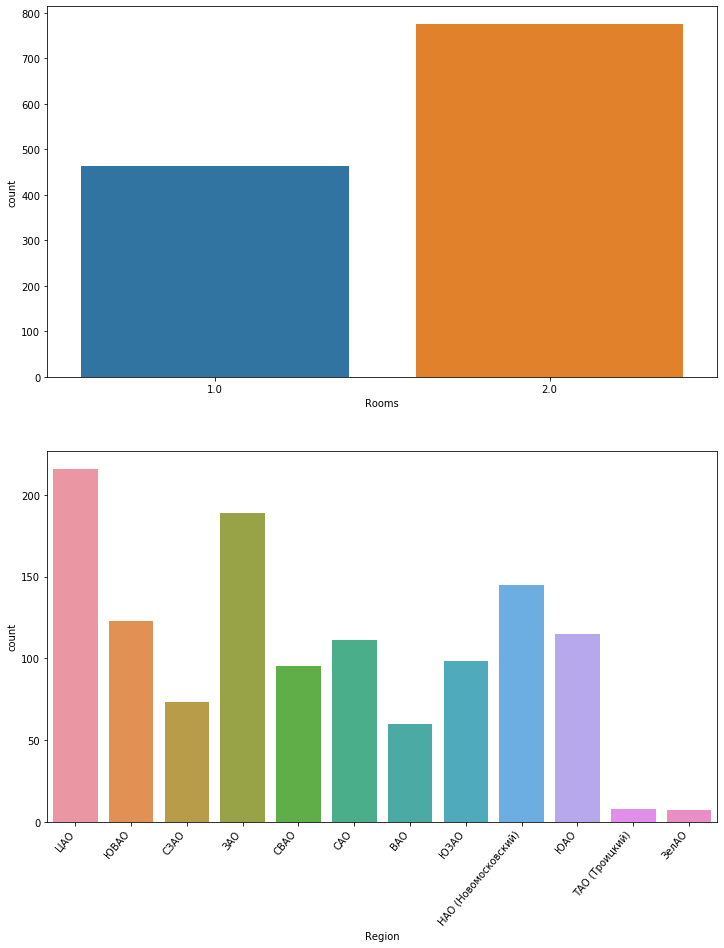

In [12]:
# plot 
fig, ax =plt.subplots(2,1, figsize=(12,15))
sns.countplot(df['Rooms'], ax=ax[0])
sns.countplot(df['Region'], ax=ax[1])
ax[1].set_xticklabels(ax[1].get_xticklabels(), rotation=50, ha="right") 

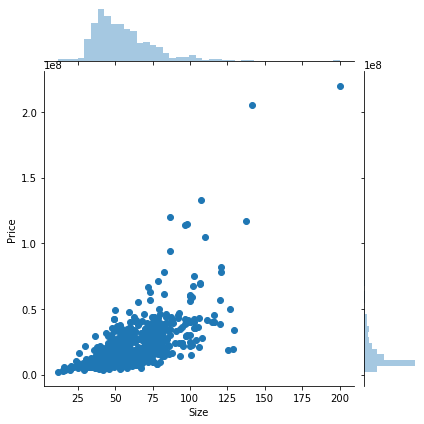

In [13]:
# chech for outliers
sns.jointplot(x='Size', y='Price', data=df[['Size','Price']])

In [14]:
out_down = df['Price/m2'].quantile(0.025)
out_down

124047.60925000001

In [15]:
out_up = df['Price/m2'].quantile(0.975)
out_up

665041.6667499997

In [16]:
# remove outliers
df = df[df['Price/m2'] < 665041]
df = df[df['Price/m2'] > 124047]
len(df)

1178

In [17]:
df.head()

Unnamed: 0       Price  Rooms  Size    Town Region         District  \
0           0  28000000.0    2.0  56.0  Москва    ЦАО  р-н Пресненский   
1           1   5392000.0    1.0  16.0  Москва    ЦАО    р-н Басманный   
3           3   5406652.0    1.0  35.6  Москва   ЮВАО   р-н Некрасовка   
5           5   5656010.0    1.0  38.5  Москва   ЮВАО   р-н Некрасовка   
6           6   5743766.0    1.0  39.1  Москва   ЮВАО   р-н Некрасовка   

                         Street House   Price/m2  
0  1-й Красногвардейский проезд  22с2  500000.00  
1            Старокирочный пер.     6  337000.00  
3             ул. Вертолетчиков     4  151872.25  
5                ул. Лавриненко     5  146909.35  
6             ул. Вертолетчиков    13  146899.39

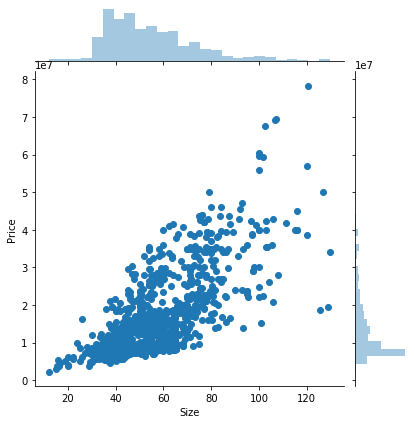

In [18]:
sns.jointplot(x='Size', y='Price', data=df[['Size','Price']])

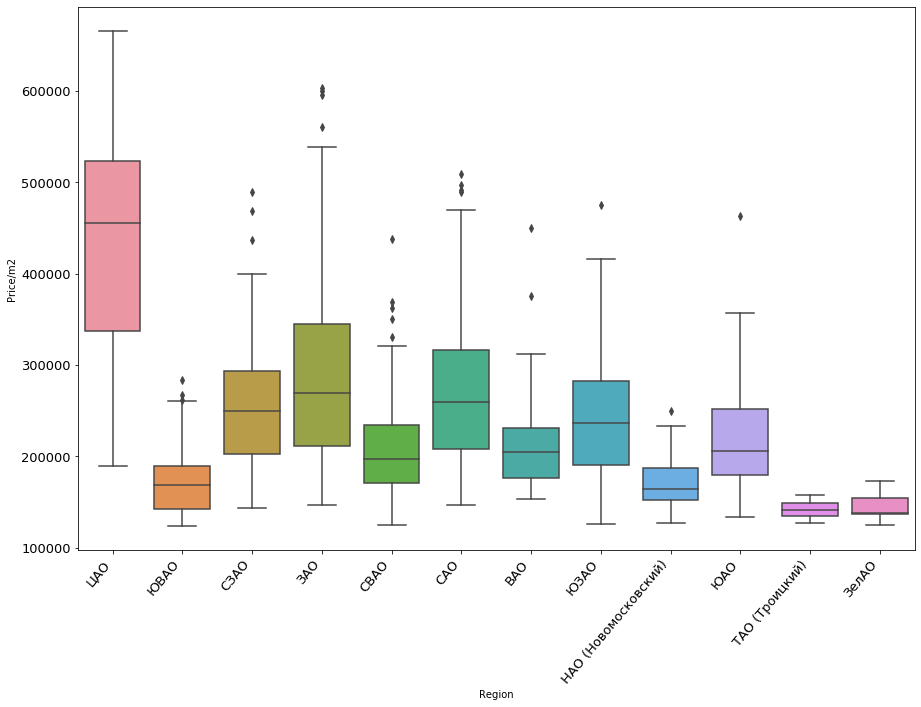

In [19]:
# check the differences in price per m2 in each region
plt.figure(figsize=(15,10))
ax = sns.boxplot(x='Region', y='Price/m2', data=df)
ax.set_xticklabels(ax.get_xticklabels(), rotation=50, ha="right")
ax.tick_params(labelsize=13)

### 3. Find coordinates

In [15]:
# create address column
df['Address'] = (df['Town']+' '+ df['Street'] + ' '+ df['House'])
df.head()

Unnamed: 0       Price  Rooms  Size    Town Region         District  \
0           0  28000000.0    2.0  56.0  Москва    ЦАО  р-н Пресненский   
1           1   5392000.0    1.0  16.0  Москва    ЦАО    р-н Басманный   
3           3   5406652.0    1.0  35.6  Москва   ЮВАО   р-н Некрасовка   
5           5   5656010.0    1.0  38.5  Москва   ЮВАО   р-н Некрасовка   
6           6   5743766.0    1.0  39.1  Москва   ЮВАО   р-н Некрасовка   

                         Street House   Price/m2  \
0  1-й Красногвардейский проезд  22с2  500000.00   
1            Старокирочный пер.     6  337000.00   
3             ул. Вертолетчиков     4  151872.25   
5                ул. Лавриненко     5  146909.35   
6             ул. Вертолетчиков    13  146899.39   

                                    Address  
0  Москва 1-й Красногвардейский проезд 22с2  
1               Москва Старокирочный пер. 6  
3                Москва ул. Вертолетчиков 4  
5                   Москва ул. Лавриненко 5  
6               Москва ул. Вертолетчиков 13

In [200]:
# create dataframe with addresses to find coordinates for each
moscow_districts = df[['Address']].drop_duplicates().sort_values(by=['Address']).reset_index(drop=True)
moscow_districts['Address'] = moscow_districts['Address'].str.replace(' ', '+')
moscow_districts

Address
0               Москва+1-й+Басманный+пер.+5/20С2
1       Москва+1-й+Красногвардейский+проезд+21с1
2       Москва+1-й+Красногвардейский+проезд+21с2
3       Москва+1-й+Красногвардейский+проезд+22с2
4    Москва+1-й+Красногвардейский+проезд+вл17-18
..                                           ...
774                     Москва+ул.+Шолохова+28К1
775                        Москва+ул.+Шолохова+7
776                         Москва+ул.+Шухова+18
777                   Москва+ш.+Энтузиастов+98К1
778                                          NaN

[779 rows x 1 columns]

In [201]:
latitude = np.zeros(moscow_districts.shape[0])
longitude = np.zeros(moscow_districts.shape[0])
moscow_districts.head()

Address
0             Москва+1-й+Басманный+пер.+5/20С2
1     Москва+1-й+Красногвардейский+проезд+21с1
2     Москва+1-й+Красногвардейский+проезд+21с2
3     Москва+1-й+Красногвардейский+проезд+22с2
4  Москва+1-й+Красногвардейский+проезд+вл17-18

In [205]:
# use your API key to get the coordinates
n = 0
for i in range(moscow_districts.shape[0]):
    if n < 779:
        address = moscow_districts['Address'][n]
    else:
        break
    
    url_part1 = 'https://geocode-maps.yandex.ru/1.x/?apikey='Your API Key'&geocode='
    url_part2 = str(address)
    url = url_part1 + url_part2
    response = requests.get(url)
    xml = response.text
    soup = BeautifulSoup(xml,'html.parser') 
    coordinates = soup.find('pos').text.split()
    
    latitude[i] = coordinates[1]
    longitude[i] = coordinates[0]
    n = n+1

In [208]:
latitude[1]

55.750028

In [209]:
# create dataframe with coordinates for each flat address
district_coordinates = moscow_districts
district_coordinates['Latitude'] = latitude
district_coordinates['Longitude'] = longitude
district_coordinates

Address   Latitude   Longitude
0               Москва+1-й+Басманный+пер.+5/20С2  55.771489   37.662794
1       Москва+1-й+Красногвардейский+проезд+21с1  55.750028   37.534397
2       Москва+1-й+Красногвардейский+проезд+21с2  55.749380   37.534092
3       Москва+1-й+Красногвардейский+проезд+22с2  55.751568   37.535332
4    Москва+1-й+Красногвардейский+проезд+вл17-18  55.751138   37.533742
..                                           ...        ...         ...
774                     Москва+ул.+Шолохова+28К1  55.643840   37.345311
775                        Москва+ул.+Шолохова+7  55.638861   37.349174
776                         Москва+ул.+Шухова+18  55.716899   37.610431
777                   Москва+ш.+Энтузиастов+98К1  55.773186   37.832593
778                                          NaN  18.807682  100.771535

[779 rows x 3 columns]

In [210]:
# create map of Moscow using latitude and longitude values
map_moscow = folium.Map(location=[55.753215, 37.622504], zoom_start=12)

# add markers to map
for lat, lng, address in zip(district_coordinates['Latitude'], district_coordinates['Longitude'], district_coordinates['Address']):
    label = '{}'.format(address)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_moscow)  
    
map_moscow

In [219]:
# lets find coordinates for each district
moscow_distr = df[['District']].drop_duplicates().sort_values(by=['District']).reset_index(drop=True)
moscow_distr['District'] = moscow_distr['District'].str.replace(' ', '+')
moscow_distr

District
0       Внуковское+поселение
1    Воскресенское+поселение
2      Десеновское+поселение
3         Коммунарка+поселок
4     Марушкинское+поселение
..                       ...
125         р-н+Южное+Тушино
126         р-н+Южнопортовый
127             р-н+Якиманка
128          р-н+Ярославский
129              р-н+Ясенево

[130 rows x 1 columns]

In [220]:
moscow_distr['District'] = 'Москва+' + moscow_distr['District']
moscow_distr

District
0       Москва+Внуковское+поселение
1    Москва+Воскресенское+поселение
2      Москва+Десеновское+поселение
3         Москва+Коммунарка+поселок
4     Москва+Марушкинское+поселение
..                              ...
125         Москва+р-н+Южное+Тушино
126         Москва+р-н+Южнопортовый
127             Москва+р-н+Якиманка
128          Москва+р-н+Ярославский
129              Москва+р-н+Ясенево

[130 rows x 1 columns]

In [221]:
lat = np.zeros(moscow_distr.shape[0])
long = np.zeros(moscow_distr.shape[0])
moscow_distr.head()

District
0     Москва+Внуковское+поселение
1  Москва+Воскресенское+поселение
2    Москва+Десеновское+поселение
3       Москва+Коммунарка+поселок
4   Москва+Марушкинское+поселение

In [222]:
n = 0
for i in range(moscow_distr.shape[0]):
    if n < 130:
        distr = moscow_distr['District'][n]
    else:
        break
    
    url_part1 = 'https://geocode-maps.yandex.ru/1.x/?apikey=6d542c7b-6a68-4464-a711-29b2e44f53b3&geocode='
    url_part2 = str(distr)
    url = url_part1 + url_part2
    response = requests.get(url)
    xml = response.text
    soup = BeautifulSoup(xml,'html.parser') 
    coordinates = soup.find('pos').text.split()
    
    lat[i] = coordinates[1]
    long[i] = coordinates[0]
    n = n+1

In [223]:
lat[1]

55.527326

In [224]:
distr_coordinates = moscow_distr
distr_coordinates['Latitude'] = lat
distr_coordinates['Longitude'] = long
distr_coordinates

District   Latitude  Longitude
0       Москва+Внуковское+поселение  55.633500  37.290298
1    Москва+Воскресенское+поселение  55.527326  37.443200
2      Москва+Десеновское+поселение  55.499571  37.366610
3         Москва+Коммунарка+поселок  55.755814  37.617635
4     Москва+Марушкинское+поселение  55.595160  37.208273
..                              ...        ...        ...
125         Москва+р-н+Южное+Тушино  55.843434  37.431423
126         Москва+р-н+Южнопортовый  55.713086  37.670474
127             Москва+р-н+Якиманка  55.730826  37.607565
128          Москва+р-н+Ярославский  55.862858  37.697460
129              Москва+р-н+Ясенево  55.607514  37.534577

[130 rows x 3 columns]

In [225]:
# create map of Moscow using latitude and longitude values
map_msc = folium.Map(location=[55.753215, 37.622504], zoom_start=12)

# add markers to map
for lat, lng, district in zip(distr_coordinates['Latitude'], distr_coordinates['Longitude'], distr_coordinates['District']):
    label = '{}'.format(district)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_msc)  
    
map_msc

In [226]:
distr_coordinates['District'] = distr_coordinates['District'].str.replace('+', ' ')
distr_coordinates.head()

District   Latitude  Longitude
0     Москва Внуковское поселение  55.633500  37.290298
1  Москва Воскресенское поселение  55.527326  37.443200
2    Москва Десеновское поселение  55.499571  37.366610
3       Москва Коммунарка поселок  55.755814  37.617635
4   Москва Марушкинское поселение  55.595160  37.208273

In [227]:
distr_coordinates['District'] = distr_coordinates['District'].str.replace('Москва ', '')
distr_coordinates

District   Latitude  Longitude
0       Внуковское поселение  55.633500  37.290298
1    Воскресенское поселение  55.527326  37.443200
2      Десеновское поселение  55.499571  37.366610
3         Коммунарка поселок  55.755814  37.617635
4     Марушкинское поселение  55.595160  37.208273
..                       ...        ...        ...
125         р-н Южное Тушино  55.843434  37.431423
126         р-н Южнопортовый  55.713086  37.670474
127             р-н Якиманка  55.730826  37.607565
128          р-н Ярославский  55.862858  37.697460
129              р-н Ясенево  55.607514  37.534577

[130 rows x 3 columns]

In [228]:
# lets create a dataframe with all flats data and their district coordinates to find all venues nearby
full_data = pd.merge(left=df, right=distr_coordinates, how='left', left_on='District', right_on='District')
full_data.head()

Unnamed: 0       Price  Rooms  Size    Town Region         District  \
0           0  28000000.0    2.0  56.0  Москва    ЦАО  р-н Пресненский   
1           1   5392000.0    1.0  16.0  Москва    ЦАО    р-н Басманный   
2           3   5406652.0    1.0  35.6  Москва   ЮВАО   р-н Некрасовка   
3           5   5656010.0    1.0  38.5  Москва   ЮВАО   р-н Некрасовка   
4           6   5743766.0    1.0  39.1  Москва   ЮВАО   р-н Некрасовка   

                         Street House   Price/m2  \
0  1-й Красногвардейский проезд  22с2  500000.00   
1            Старокирочный пер.     6  337000.00   
2             ул. Вертолетчиков     4  151872.25   
3                ул. Лавриненко     5  146909.35   
4             ул. Вертолетчиков    13  146899.39   

                                    Address   Latitude  Longitude  
0  Москва 1-й Красногвардейский проезд 22с2  55.763432  37.562389  
1               Москва Старокирочный пер. 6  55.766567  37.671229  
2                Москва ул. Вертолетчиков 4  55.683793  37.928704  
3                   Москва ул. Лавриненко 5  55.683793  37.928704  
4               Москва ул. Вертолетчиков 13  55.683793  37.928704

In [21]:
# create a dataframe with average price by district
mean_per_district = full_data.groupby('District').mean().reset_index()
mean_per_district

District  Unnamed: 0  Unnamed: 0.1         Price  \
0       Внуковское поселение  435.916667    570.208333  8.550417e+06   
1    Воскресенское поселение  439.750000    583.750000  7.575000e+06   
2      Десеновское поселение  441.900000    585.700000  7.291000e+06   
3         Коммунарка поселок  553.529412    707.235294  7.971176e+06   
4     Марушкинское поселение  306.500000    437.000000  7.150000e+06   
..                       ...         ...           ...           ...   
125         р-н Южное Тушино  514.000000    647.000000  1.149000e+07   
126         р-н Южнопортовый  689.600000    848.800000  1.340000e+07   
127             р-н Якиманка  991.000000   1170.000000  4.033333e+07   
128          р-н Ярославский  285.750000    378.500000  5.491812e+06   
129              р-н Ясенево  252.000000    375.500000  1.068000e+07   

        Rooms       Size       Price/m2   Latitude  Longitude  
0    1.291667  47.333333  180645.263750  55.633500  37.290298  
1    1.500000  52.000000  145546.985000  55.527326  37.443200  
2    1.300000  46.550000  156829.279000  55.499571  37.366610  
3    1.352941  44.747059  181391.181176  55.755814  37.617635  
4    1.500000  44.500000  159806.910000  55.595160  37.208273  
..        ...        ...            ...        ...        ...  
125  2.000000  53.000000  216792.450000  55.843434  37.431423  
126  2.000000  53.020000  254141.378000  55.713086  37.670474  
127  2.000000  68.033333  597249.783333  55.730826  37.607565  
128  1.250000  37.212500  149908.623750  55.862858  37.697460  
129  2.000000  49.650000  213230.930000  55.607514  37.534577  

[130 rows x 9 columns]

In [22]:
mean_per_district['District'] = mean_per_district['District'].str.replace('р-н ', '')
mean_per_district['District'] = mean_per_district['District'].str.replace(' поселение', '')
mean_per_district['District'] = mean_per_district['District'].str.replace(' поселок', '')
mean_per_district['District'] = mean_per_district['District'].str.replace(' поселок', '')
mean_per_district

District  Unnamed: 0  Unnamed: 0.1         Price     Rooms  \
0       Внуковское  435.916667    570.208333  8.550417e+06  1.291667   
1    Воскресенское  439.750000    583.750000  7.575000e+06  1.500000   
2      Десеновское  441.900000    585.700000  7.291000e+06  1.300000   
3       Коммунарка  553.529412    707.235294  7.971176e+06  1.352941   
4     Марушкинское  306.500000    437.000000  7.150000e+06  1.500000   
..             ...         ...           ...           ...       ...   
125   Южное Тушино  514.000000    647.000000  1.149000e+07  2.000000   
126   Южнопортовый  689.600000    848.800000  1.340000e+07  2.000000   
127       Якиманка  991.000000   1170.000000  4.033333e+07  2.000000   
128    Ярославский  285.750000    378.500000  5.491812e+06  1.250000   
129        Ясенево  252.000000    375.500000  1.068000e+07  2.000000   

          Size       Price/m2   Latitude  Longitude  
0    47.333333  180645.263750  55.633500  37.290298  
1    52.000000  145546.985000  55.527326  37.443200  
2    46.550000  156829.279000  55.499571  37.366610  
3    44.747059  181391.181176  55.755814  37.617635  
4    44.500000  159806.910000  55.595160  37.208273  
..         ...            ...        ...        ...  
125  53.000000  216792.450000  55.843434  37.431423  
126  53.020000  254141.378000  55.713086  37.670474  
127  68.033333  597249.783333  55.730826  37.607565  
128  37.212500  149908.623750  55.862858  37.697460  
129  49.650000  213230.930000  55.607514  37.534577  

[130 rows x 9 columns]

### Average price/m2 per district

In [23]:
# I've downloaded the file with geodata on Moscow districts from the gislab website ('https://gis-lab.info/qa/moscow-atd.html')
with open('mo.geojson') as json_data:
    location_data = json.load(json_data)

In [24]:
moscow_geo = location_data

# create a plain map of Moscow
moscow_map = folium.Map(location=[55.753215, 37.622504], zoom_start=12)

# add the data
moscow_map.choropleth(
    geo_data=location_data,
    data=mean_per_district,
    columns=['District', 'Price/m2'],
    key_on='feature.properties.NAME',
    fill_color='YlOrRd', 
    fill_opacity=0.7, 
    line_opacity=0.2,
    legend_name='Average price/m2 for each district in Moscow'
)

# add markers to map
for lat, lng, district in zip(mean_per_district['Latitude'], mean_per_district['Longitude'], mean_per_district['District']):
    label = '{}'.format(district)
    label = folium.Popup(label, parse_html=True)
    folium.Circle(
        [lat, lng],
        radius=100,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(moscow_map) 

# display map
moscow_map

### 4. Get venues data from Foursquare

In [252]:
CLIENT_ID = 'Your ID' # your Foursquare ID
CLIENT_SECRET = 'Your Secret' # your Foursquare Secret
VERSION = 'Version' # Foursquare API version
limit=100

In [253]:
def getNearbyVenues(names, latitudes,longitudes, radius=5000):
    
    venues_list=[]
    for name, lat, lng in zip(names,latitudes,longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            limit)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [ ]:
moscow_venues = getNearbyVenues(names=mean_per_district['District'],
                                   latitudes=mean_per_district['Latitude'],
                                   longitudes=mean_per_district['Longitude'],
                                  )

In [256]:
print(moscow_venues.shape)
moscow_venues.head()

(11522, 8)


Unnamed: 0 Neighborhood  Neighborhood Latitude  Neighborhood Longitude  \
0           0   Внуковское                55.6335               37.290298   
1           1   Внуковское                55.6335               37.290298   
2           2   Внуковское                55.6335               37.290298   
3           3   Внуковское                55.6335               37.290298   
4           4   Внуковское                55.6335               37.290298   

                              Venue  Venue Latitude  Venue Longitude  \
0                Парк «Рассказовка»       55.631868        37.319802   
1                       Шоколадница       55.622265        37.289783   
2   Салон красоты Наталии Волошиной       55.643984        37.343332   
3                           Selgros       55.629225        37.309528   
4  Turkish Airlines Istanbul Lounge       55.602476        37.280865   

       Venue Category  
0                Park  
1                Café  
2  Salon / Barbershop  
3       Big Box Store  
4      Airport Lounge

In [26]:
print('{} venues are collected'.format(moscow_venues.shape[0]))

11522 venues are collected


In [27]:
moscow_venues.groupby('Neighborhood').count()

Unnamed: 0  Unnamed: 0.1  Neighborhood Latitude  \
Neighborhood                                                     
Академический         100           100                    100   
Алтуфьевский          100           100                    100   
Арбат                 100           100                    100   
Аэропорт               51            51                     51   
Басманный             100           100                    100   
...                   ...           ...                    ...   
Южное Тушино          100           100                    100   
Южнопортовый          100           100                    100   
Якиманка              100           100                    100   
Ярославский             2             2                      2   
Ясенево               100           100                    100   

               Neighborhood Longitude  Venue  Venue Latitude  Venue Longitude  \
Neighborhood                                                                    
Академический                     100    100             100              100   
Алтуфьевский                      100    100             100              100   
Арбат                             100    100             100              100   
Аэропорт                           51     51              51               51   
Басманный                         100    100             100              100   
...                               ...    ...             ...              ...   
Южное Тушино                      100    100             100              100   
Южнопортовый                      100    100             100              100   
Якиманка                          100    100             100              100   
Ярославский                         2      2               2                2   
Ясенево                           100    100             100              100   

               Venue Category  
Neighborhood                   
Академический             100  
Алтуфьевский              100  
Арбат                     100  
Аэропорт                   51  
Басманный                 100  
...                       ...  
Южное Тушино              100  
Южнопортовый              100  
Якиманка                  100  
Ярославский                 2  
Ясенево                   100  

[126 rows x 8 columns]

In [28]:
print('There are {} uniques categories.'.format(len(moscow_venues['Venue Category'].unique())))

There are 328 uniques categories.


### Lets analyse each district

In [29]:
# interim modifications
moscow_int = pd.get_dummies(moscow_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column to dataframe
moscow_int['Neighborhood'] = moscow_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [moscow_int.columns[-1]] + list(moscow_int.columns[:-1])
moscow_int = moscow_int[fixed_columns]

moscow_int.head()

Neighborhood  Accessories Store  Adult Boutique  Airport  Airport Lounge  \
0   Внуковское                  0               0        0               0   
1   Внуковское                  0               0        0               0   
2   Внуковское                  0               0        0               0   
3   Внуковское                  0               0        0               0   
4   Внуковское                  0               0        0               1   

   Airport Service  Airport Terminal  American Restaurant  Aquarium  Arcade  \
0                0                 0                    0         0       0   
1                0                 0                    0         0       0   
2                0                 0                    0         0       0   
3                0                 0                    0         0       0   
4                0                 0                    0         0       0   

   ...  Water Park  Waterfall  Waterfront  Wine Bar  Wine Shop  Wings Joint  \
0  ...           0          0           0         0          0            0   
1  ...           0          0           0         0          0            0   
2  ...           0          0           0         0          0            0   
3  ...           0          0           0         0          0            0   
4  ...           0          0           0         0          0            0   

   Women's Store  Yoga Studio  Zoo  Zoo Exhibit  
0              0            0    0            0  
1              0            0    0            0  
2              0            0    0            0  
3              0            0    0            0  
4              0            0    0            0  

[5 rows x 329 columns]

In [30]:
moscow_grouped = moscow_int.groupby('Neighborhood').mean().reset_index()
moscow_grouped

Neighborhood  Accessories Store  Adult Boutique  Airport  \
0    Академический                0.0            0.00      0.0   
1     Алтуфьевский                0.0            0.00      0.0   
2            Арбат                0.0            0.01      0.0   
3         Аэропорт                0.0            0.00      0.0   
4        Басманный                0.0            0.01      0.0   
..             ...                ...             ...      ...   
121   Южное Тушино                0.0            0.00      0.0   
122   Южнопортовый                0.0            0.01      0.0   
123       Якиманка                0.0            0.01      0.0   
124    Ярославский                0.0            0.00      0.0   
125        Ясенево                0.0            0.00      0.0   

     Airport Lounge  Airport Service  Airport Terminal  American Restaurant  \
0               0.0              0.0               0.0                  0.0   
1               0.0              0.0               0.0                  0.0   
2               0.0              0.0               0.0                  0.0   
3               0.0              0.0               0.0                  0.0   
4               0.0              0.0               0.0                  0.0   
..              ...              ...               ...                  ...   
121             0.0              0.0               0.0                  0.0   
122             0.0              0.0               0.0                  0.0   
123             0.0              0.0               0.0                  0.0   
124             0.0              0.0               0.0                  0.0   
125             0.0              0.0               0.0                  0.0   

     Aquarium    Arcade  ...  Water Park  Waterfall  Waterfront  Wine Bar  \
0        0.00  0.020000  ...        0.00        0.0        0.01      0.01   
1        0.00  0.000000  ...        0.00        0.0        0.00      0.00   
2        0.00  0.000000  ...        0.00        0.0        0.00      0.00   
3        0.00  0.019608  ...        0.00        0.0        0.00      0.00   
4        0.00  0.010000  ...        0.00        0.0        0.00      0.02   
..        ...       ...  ...         ...        ...         ...       ...   
121      0.01  0.010000  ...        0.00        0.0        0.01      0.00   
122      0.00  0.040000  ...        0.00        0.0        0.00      0.00   
123      0.00  0.020000  ...        0.00        0.0        0.01      0.00   
124      0.00  0.000000  ...        0.00        0.0        0.00      0.00   
125      0.00  0.010000  ...        0.01        0.0        0.00      0.00   

     Wine Shop  Wings Joint  Women's Store  Yoga Studio  Zoo  Zoo Exhibit  
0         0.03         0.01           0.00         0.00  0.0         0.00  
1         0.00         0.00           0.02         0.02  0.0         0.01  
2         0.02         0.00           0.00         0.05  0.0         0.00  
3         0.00         0.00           0.00         0.00  0.0         0.00  
4         0.00         0.00           0.00         0.03  0.0         0.00  
..         ...          ...            ...          ...  ...          ...  
121       0.01         0.00           0.00         0.02  0.0         0.00  
122       0.01         0.00           0.00         0.02  0.0         0.01  
123       0.02         0.00           0.00         0.04  0.0         0.00  
124       0.00         0.00           0.00         0.00  0.0         0.00  
125       0.00         0.01           0.00         0.03  0.0         0.01  

[126 rows x 329 columns]

In [31]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [32]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for idx in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(idx+1, indicators[idx]))
    except:
        columns.append('{}th Most Common Venue'.format(idx+1))

# create a new dataframe
district_venues_sorted = pd.DataFrame(columns=columns)
district_venues_sorted['Neighborhood'] = moscow_grouped['Neighborhood']

for idx in np.arange(moscow_grouped.shape[0]):
    district_venues_sorted.iloc[idx, 1:] = return_most_common_venues(moscow_grouped.iloc[idx, :], num_top_venues)

In [33]:
district_venues_sorted

Neighborhood 1st Most Common Venue 2nd Most Common Venue  \
0    Академический                  Park     Health Food Store   
1     Алтуфьевский                  Park     Health Food Store   
2            Арбат           Coffee Shop                 Hotel   
3         Аэропорт                  Café         Grocery Store   
4        Басманный           Coffee Shop                 Hotel   
..             ...                   ...                   ...   
121   Южное Тушино                  Park  Gym / Fitness Center   
122   Южнопортовый           Coffee Shop  Gym / Fitness Center   
123       Якиманка                  Park                 Hotel   
124    Ярославский         Boat or Ferry            Restaurant   
125        Ясенево                  Park           Coffee Shop   

    3rd Most Common Venue 4th Most Common Venue 5th Most Common Venue  \
0    Gym / Fitness Center           Coffee Shop        Scenic Lookout   
1    Gym / Fitness Center           Supermarket         Auto Workshop   
2                    Park           Yoga Studio                 Plaza   
3             Coffee Shop            Restaurant          Gourmet Shop   
4             Yoga Studio                Garden                   Bar   
..                    ...                   ...                   ...   
121            Restaurant           Coffee Shop             Surf Spot   
122                Arcade     Martial Arts Dojo                   Bar   
123           Coffee Shop           Yoga Studio               Theater   
124     Food & Drink Shop        Farmers Market  Fast Food Restaurant   
125  Gym / Fitness Center        Clothing Store        Cosmetics Shop   

    6th Most Common Venue 7th Most Common Venue 8th Most Common Venue  \
0               Wine Shop           Outdoor Gym                 Trail   
1              Restaurant        Clothing Store          Dance Studio   
2            Concert Hall                  Road             Bookstore   
3           Shopping Mall                Bakery          Dessert Shop   
4                    Park           Art Gallery                 Plaza   
..                    ...                   ...                   ...   
121        Cosmetics Shop          Concert Hall             Pet Store   
122     Convenience Store             Nightclub         Auto Workshop   
123           Pizza Place        Scenic Lookout          Concert Hall   
124           Film Studio           Fish Market          Fishing Spot   
125     Health Food Store                   Gym          Gourmet Shop   

    9th Most Common Venue      10th Most Common Venue  
0            Soccer Field                      Arcade  
1             Coffee Shop                 Yoga Studio  
2      Russian Restaurant                    Boutique  
3             Supermarket  Modern European Restaurant  
4    Gym / Fitness Center                 Pizza Place  
..                    ...                         ...  
121     Health Food Store                  Sports Bar  
122     Health Food Store                 Music Venue  
123                   Bar                      Garden  
124           Flea Market                 Flower Shop  
125            Beer Store                 Yoga Studio  

[126 rows x 11 columns]

### 5. Clustering

In [36]:
# set number of clusters
kclusters = 11

moscow_grouped_clustering = moscow_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(moscow_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10]

array([0, 0, 7, 6, 7, 7, 0, 0, 0, 5], dtype=int32)

In [37]:
mean_per_district.rename(columns = {'District':'Neighborhood'}, inplace = True) 

In [38]:
# add clustering labels
district_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

# add latitude/longitude for each district
moscow_merged = mean_per_district.join(district_venues_sorted.set_index('Neighborhood'), on='Neighborhood')
moscow_merged

Neighborhood  Unnamed: 0  Unnamed: 0.1         Price     Rooms  \
0       Внуковское  435.916667    570.208333  8.550417e+06  1.291667   
1    Воскресенское  439.750000    583.750000  7.575000e+06  1.500000   
2      Десеновское  441.900000    585.700000  7.291000e+06  1.300000   
3       Коммунарка  553.529412    707.235294  7.971176e+06  1.352941   
4     Марушкинское  306.500000    437.000000  7.150000e+06  1.500000   
..             ...         ...           ...           ...       ...   
125   Южное Тушино  514.000000    647.000000  1.149000e+07  2.000000   
126   Южнопортовый  689.600000    848.800000  1.340000e+07  2.000000   
127       Якиманка  991.000000   1170.000000  4.033333e+07  2.000000   
128    Ярославский  285.750000    378.500000  5.491812e+06  1.250000   
129        Ясенево  252.000000    375.500000  1.068000e+07  2.000000   

          Size       Price/m2   Latitude  Longitude  Cluster Labels  \
0    47.333333  180645.263750  55.633500  37.290298             6.0   
1    52.000000  145546.985000  55.527326  37.443200             6.0   
2    46.550000  156829.279000  55.499571  37.366610             6.0   
3    44.747059  181391.181176  55.755814  37.617635             0.0   
4    44.500000  159806.910000  55.595160  37.208273             6.0   
..         ...            ...        ...        ...             ...   
125  53.000000  216792.450000  55.843434  37.431423             0.0   
126  53.020000  254141.378000  55.713086  37.670474             5.0   
127  68.033333  597249.783333  55.730826  37.607565             7.0   
128  37.212500  149908.623750  55.862858  37.697460            10.0   
129  49.650000  213230.930000  55.607514  37.534577             5.0   

    1st Most Common Venue 2nd Most Common Venue 3rd Most Common Venue  \
0                    Café  Gym / Fitness Center       Airport Service   
1             Supermarket     Health Food Store                  Park   
2                    Park            Restaurant           Supermarket   
3                    Park        Clothing Store  Gym / Fitness Center   
4          Airport Lounge       Airport Service        Scenic Lookout   
..                    ...                   ...                   ...   
125                  Park  Gym / Fitness Center            Restaurant   
126           Coffee Shop  Gym / Fitness Center                Arcade   
127                  Park                 Hotel           Coffee Shop   
128         Boat or Ferry            Restaurant     Food & Drink Shop   
129                  Park           Coffee Shop  Gym / Fitness Center   

    4th Most Common Venue 5th Most Common Venue 6th Most Common Venue  \
0             Supermarket                Museum        Clothing Store   
1    Fast Food Restaurant   Fried Chicken Joint        Clothing Store   
2               Rest Area     Convenience Store                Resort   
3              Restaurant                  Café        Cosmetics Shop   
4             Coffee Shop        Duty-free Shop     Convenience Store   
..                    ...                   ...                   ...   
125           Coffee Shop             Surf Spot        Cosmetics Shop   
126     Martial Arts Dojo                   Bar     Convenience Store   
127           Yoga Studio               Theater           Pizza Place   
128        Farmers Market  Fast Food Restaurant           Film Studio   
129        Clothing Store        Cosmetics Shop     Health Food Store   

    7th Most Common Venue 8th Most Common Venue 9th Most Common Venue  \
0                Gym Pool     Mobile Phone Shop          Gourmet Shop   
1     Japanese Restaurant    Italian Restaurant            Restaurant   
2                  Bakery                 Trail    Italian Restaurant   
3      Italian Restaurant         Jewelry Store          Gourmet Shop   
4           Train Station                  Café             Racetrack   
..                    ...                   ...                   ...   
125          Concert Ha

In [39]:
moscow_merged['Cluster Labels']= moscow_merged['Cluster Labels'].replace('.0', '')
moscow_merged

Neighborhood  Unnamed: 0  Unnamed: 0.1         Price     Rooms  \
0       Внуковское  435.916667    570.208333  8.550417e+06  1.291667   
1    Воскресенское  439.750000    583.750000  7.575000e+06  1.500000   
2      Десеновское  441.900000    585.700000  7.291000e+06  1.300000   
3       Коммунарка  553.529412    707.235294  7.971176e+06  1.352941   
4     Марушкинское  306.500000    437.000000  7.150000e+06  1.500000   
..             ...         ...           ...           ...       ...   
125   Южное Тушино  514.000000    647.000000  1.149000e+07  2.000000   
126   Южнопортовый  689.600000    848.800000  1.340000e+07  2.000000   
127       Якиманка  991.000000   1170.000000  4.033333e+07  2.000000   
128    Ярославский  285.750000    378.500000  5.491812e+06  1.250000   
129        Ясенево  252.000000    375.500000  1.068000e+07  2.000000   

          Size       Price/m2   Latitude  Longitude  Cluster Labels  \
0    47.333333  180645.263750  55.633500  37.290298             6.0   
1    52.000000  145546.985000  55.527326  37.443200             6.0   
2    46.550000  156829.279000  55.499571  37.366610             6.0   
3    44.747059  181391.181176  55.755814  37.617635             0.0   
4    44.500000  159806.910000  55.595160  37.208273             6.0   
..         ...            ...        ...        ...             ...   
125  53.000000  216792.450000  55.843434  37.431423             0.0   
126  53.020000  254141.378000  55.713086  37.670474             5.0   
127  68.033333  597249.783333  55.730826  37.607565             7.0   
128  37.212500  149908.623750  55.862858  37.697460            10.0   
129  49.650000  213230.930000  55.607514  37.534577             5.0   

    1st Most Common Venue 2nd Most Common Venue 3rd Most Common Venue  \
0                    Café  Gym / Fitness Center       Airport Service   
1             Supermarket     Health Food Store                  Park   
2                    Park            Restaurant           Supermarket   
3                    Park        Clothing Store  Gym / Fitness Center   
4          Airport Lounge       Airport Service        Scenic Lookout   
..                    ...                   ...                   ...   
125                  Park  Gym / Fitness Center            Restaurant   
126           Coffee Shop  Gym / Fitness Center                Arcade   
127                  Park                 Hotel           Coffee Shop   
128         Boat or Ferry            Restaurant     Food & Drink Shop   
129                  Park           Coffee Shop  Gym / Fitness Center   

    4th Most Common Venue 5th Most Common Venue 6th Most Common Venue  \
0             Supermarket                Museum        Clothing Store   
1    Fast Food Restaurant   Fried Chicken Joint        Clothing Store   
2               Rest Area     Convenience Store                Resort   
3              Restaurant                  Café        Cosmetics Shop   
4             Coffee Shop        Duty-free Shop     Convenience Store   
..                    ...                   ...                   ...   
125           Coffee Shop             Surf Spot        Cosmetics Shop   
126     Martial Arts Dojo                   Bar     Convenience Store   
127           Yoga Studio               Theater           Pizza Place   
128        Farmers Market  Fast Food Restaurant           Film Studio   
129        Clothing Store        Cosmetics Shop     Health Food Store   

    7th Most Common Venue 8th Most Common Venue 9th Most Common Venue  \
0                Gym Pool     Mobile Phone Shop          Gourmet Shop   
1     Japanese Restaurant    Italian Restaurant            Restaurant   
2                  Bakery                 Trail    Italian Restaurant   
3      Italian Restaurant         Jewelry Store          Gourmet Shop   
4           Train Station                  Café             Racetrack   
..                    ...                   ...                   ...   
125          Concert Ha

In [40]:
moscow_merged

Neighborhood  Unnamed: 0  Unnamed: 0.1         Price     Rooms  \
0       Внуковское  435.916667    570.208333  8.550417e+06  1.291667   
1    Воскресенское  439.750000    583.750000  7.575000e+06  1.500000   
2      Десеновское  441.900000    585.700000  7.291000e+06  1.300000   
3       Коммунарка  553.529412    707.235294  7.971176e+06  1.352941   
4     Марушкинское  306.500000    437.000000  7.150000e+06  1.500000   
..             ...         ...           ...           ...       ...   
125   Южное Тушино  514.000000    647.000000  1.149000e+07  2.000000   
126   Южнопортовый  689.600000    848.800000  1.340000e+07  2.000000   
127       Якиманка  991.000000   1170.000000  4.033333e+07  2.000000   
128    Ярославский  285.750000    378.500000  5.491812e+06  1.250000   
129        Ясенево  252.000000    375.500000  1.068000e+07  2.000000   

          Size       Price/m2   Latitude  Longitude  Cluster Labels  \
0    47.333333  180645.263750  55.633500  37.290298             6.0   
1    52.000000  145546.985000  55.527326  37.443200             6.0   
2    46.550000  156829.279000  55.499571  37.366610             6.0   
3    44.747059  181391.181176  55.755814  37.617635             0.0   
4    44.500000  159806.910000  55.595160  37.208273             6.0   
..         ...            ...        ...        ...             ...   
125  53.000000  216792.450000  55.843434  37.431423             0.0   
126  53.020000  254141.378000  55.713086  37.670474             5.0   
127  68.033333  597249.783333  55.730826  37.607565             7.0   
128  37.212500  149908.623750  55.862858  37.697460            10.0   
129  49.650000  213230.930000  55.607514  37.534577             5.0   

    1st Most Common Venue 2nd Most Common Venue 3rd Most Common Venue  \
0                    Café  Gym / Fitness Center       Airport Service   
1             Supermarket     Health Food Store                  Park   
2                    Park            Restaurant           Supermarket   
3                    Park        Clothing Store  Gym / Fitness Center   
4          Airport Lounge       Airport Service        Scenic Lookout   
..                    ...                   ...                   ...   
125                  Park  Gym / Fitness Center            Restaurant   
126           Coffee Shop  Gym / Fitness Center                Arcade   
127                  Park                 Hotel           Coffee Shop   
128         Boat or Ferry            Restaurant     Food & Drink Shop   
129                  Park           Coffee Shop  Gym / Fitness Center   

    4th Most Common Venue 5th Most Common Venue 6th Most Common Venue  \
0             Supermarket                Museum        Clothing Store   
1    Fast Food Restaurant   Fried Chicken Joint        Clothing Store   
2               Rest Area     Convenience Store                Resort   
3              Restaurant                  Café        Cosmetics Shop   
4             Coffee Shop        Duty-free Shop     Convenience Store   
..                    ...                   ...                   ...   
125           Coffee Shop             Surf Spot        Cosmetics Shop   
126     Martial Arts Dojo                   Bar     Convenience Store   
127           Yoga Studio               Theater           Pizza Place   
128        Farmers Market  Fast Food Restaurant           Film Studio   
129        Clothing Store        Cosmetics Shop     Health Food Store   

    7th Most Common Venue 8th Most Common Venue 9th Most Common Venue  \
0                Gym Pool     Mobile Phone Shop          Gourmet Shop   
1     Japanese Restaurant    Italian Restaurant            Restaurant   
2                  Bakery                 Trail    Italian Restaurant   
3      Italian Restaurant         Jewelry Store          Gourmet Shop   
4           Train Station                  Café             Racetrack   
..                    ...                   ...                   ...   
125          Concert Ha

In [44]:
moscow_merged['Cluster Labels'] =  moscow_merged['Cluster Labels'].astype(int)

In [45]:
moscow_merged['Cluster Labels'].value_counts()

0     58
5     32
6     20
7     13
10     1
9      1
8      1
4      1
3      1
2      1
1      1
Name: Cluster Labels, dtype: int64

In [46]:
moscow_merged

Neighborhood  Unnamed: 0  Unnamed: 0.1         Price     Rooms  \
0       Внуковское  435.916667    570.208333  8.550417e+06  1.291667   
1    Воскресенское  439.750000    583.750000  7.575000e+06  1.500000   
2      Десеновское  441.900000    585.700000  7.291000e+06  1.300000   
3       Коммунарка  553.529412    707.235294  7.971176e+06  1.352941   
4     Марушкинское  306.500000    437.000000  7.150000e+06  1.500000   
..             ...         ...           ...           ...       ...   
125   Южное Тушино  514.000000    647.000000  1.149000e+07  2.000000   
126   Южнопортовый  689.600000    848.800000  1.340000e+07  2.000000   
127       Якиманка  991.000000   1170.000000  4.033333e+07  2.000000   
128    Ярославский  285.750000    378.500000  5.491812e+06  1.250000   
129        Ясенево  252.000000    375.500000  1.068000e+07  2.000000   

          Size       Price/m2   Latitude  Longitude  Cluster Labels  \
0    47.333333  180645.263750  55.633500  37.290298               6   
1    52.000000  145546.985000  55.527326  37.443200               6   
2    46.550000  156829.279000  55.499571  37.366610               6   
3    44.747059  181391.181176  55.755814  37.617635               0   
4    44.500000  159806.910000  55.595160  37.208273               6   
..         ...            ...        ...        ...             ...   
125  53.000000  216792.450000  55.843434  37.431423               0   
126  53.020000  254141.378000  55.713086  37.670474               5   
127  68.033333  597249.783333  55.730826  37.607565               7   
128  37.212500  149908.623750  55.862858  37.697460              10   
129  49.650000  213230.930000  55.607514  37.534577               5   

    1st Most Common Venue 2nd Most Common Venue 3rd Most Common Venue  \
0                    Café  Gym / Fitness Center       Airport Service   
1             Supermarket     Health Food Store                  Park   
2                    Park            Restaurant           Supermarket   
3                    Park        Clothing Store  Gym / Fitness Center   
4          Airport Lounge       Airport Service        Scenic Lookout   
..                    ...                   ...                   ...   
125                  Park  Gym / Fitness Center            Restaurant   
126           Coffee Shop  Gym / Fitness Center                Arcade   
127                  Park                 Hotel           Coffee Shop   
128         Boat or Ferry            Restaurant     Food & Drink Shop   
129                  Park           Coffee Shop  Gym / Fitness Center   

    4th Most Common Venue 5th Most Common Venue 6th Most Common Venue  \
0             Supermarket                Museum        Clothing Store   
1    Fast Food Restaurant   Fried Chicken Joint        Clothing Store   
2               Rest Area     Convenience Store                Resort   
3              Restaurant                  Café        Cosmetics Shop   
4             Coffee Shop        Duty-free Shop     Convenience Store   
..                    ...                   ...                   ...   
125           Coffee Shop             Surf Spot        Cosmetics Shop   
126     Martial Arts Dojo                   Bar     Convenience Store   
127           Yoga Studio               Theater           Pizza Place   
128        Farmers Market  Fast Food Restaurant           Film Studio   
129        Clothing Store        Cosmetics Shop     Health Food Store   

    7th Most Common Venue 8th Most Common Venue 9th Most Common Venue  \
0                Gym Pool     Mobile Phone Shop          Gourmet Shop   
1     Japanese Restaurant    Italian Restaurant            Restaurant   
2                  Bakery                 Trail    Italian Restaurant   
3      Italian Restaurant         Jewelry Store          Gourmet Shop   
4           Train Station                  Café             Racetrack   
..                    ...                   ...                   ...   
125          Concert Ha

In [26]:
moscow_merged.dropna(inplace=True)

In [47]:
# create map
map_clusters = folium.Map(location=[55.753215, 37.622504], zoom_start=12)

# set colors
rainbow = ['blue', 'red', 'green', 'purple', 'orange', 'darkred','pink', 'lightblue', 'gray', 'black', 'white', 'lightgrey']

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(moscow_merged['Latitude'], moscow_merged['Longitude'], moscow_merged['Neighborhood'], moscow_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster],
        fill=True,
        fill_color=rainbow[cluster],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

In [49]:
# final visualization with all data
moscow_geo = location_data

# create a plain map of Moscow
moscow_map_final = folium.Map(location=[55.753215, 37.622504], zoom_start=12)

# add the data
moscow_map_final.choropleth(
    geo_data=location_data,
    data=mean_per_district,
    columns=['Neighborhood', 'Price/m2'],
    key_on='feature.properties.NAME',
    fill_color='YlOrRd', 
    fill_opacity=0.7, 
    line_opacity=0.2,
    legend_name='Average price/m2 for each district in Moscow'
)

# set colors
rainbow = ['blue', 'red', 'green', 'purple', 'orange', 'darkred','pink', 'lightblue', 'gray', 'black', 'white', 'lightgrey']

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(moscow_merged['Latitude'], moscow_merged['Longitude'], moscow_merged['Neighborhood'], moscow_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster],
        fill=True,
        fill_color=rainbow[cluster],
        fill_opacity=0.7).add_to(moscow_map_final)
       
moscow_map_final

### Examine clusters

In [29]:
cluster1 = moscow_merged.loc[moscow_merged['Cluster Labels'] == 0, moscow_merged.columns[[0] + list(range(5, moscow_merged.shape[1]))]]
cluster1

Neighborhood       Size       Price/m2   Latitude  \
3                   Коммунарка  44.747059  181391.181176  55.755814   
10                    Щербинка  42.500000  157214.285000  55.509034   
11               Академический  63.238889  302697.381111  55.688005   
13                Алтуфьевский  37.625000  187058.515000  55.879849   
19             Бескудниковский  32.000000  196562.500000  55.870056   
20                    Бибирево  39.471429  191089.107143  55.894768   
21          Бирюлево Восточное  50.441176  153228.715882  55.594585   
24                    Братеево  50.950000  175673.175000  55.633434   
26                     Вешняки  48.183333  195433.213333  55.730771   
28                  Войковский  59.400000  269150.411667  55.827247   
29          Восточное Дегунино  46.560000  192467.846000  55.884277   
31             Выхино-Жулебино  41.790000  177876.856000  55.696357   
33                 Головинский  37.750000  190926.722500  55.846765   
40           Западное Дегунино  34.960000  212860.534000  55.872157   
42                   Зябликово  33.000000  180303.030000  55.620423   
45                     Капотня  39.000000  148717.950000  55.637840   
46                    Коньково  63.900000  274699.325000  55.643414   
47                     Коптево  35.700000  192933.060000  55.832515   
49                    Котловка  38.533333  215456.963333  55.676209   
51                  Крылатское  69.040000  234766.232000  55.763194   
53                   Кузьминки  42.300000  192780.182500  55.698640   
54                     Кунцево  55.312500  247279.136250  55.742610   
58            Лосиноостровский  47.317692  176777.039231  55.881268   
59                     Люблино  50.850000  183443.235000  55.677717   
62                     Марьино  42.240000  179493.323000  55.652664   
65                      Митино  51.535000  174740.290000  55.845370   
66                   Можайский  64.878750  208844.730833  55.717634   
68        Москворечье-Сабурово  37.233333  196245.830000  55.642692   
77                 Обручевский  68.457143  279791.258571  55.660917   
78   Орехово-Борисово Северное  40.733333  209645.840000  55.618278   
79      Орехово-Борисово Южное  52.080000  194892.220000  55.604264   
81                    Отрадное  40.000000  221835.605556  55.862060   
82         Очаково-Матвеевское  66.552000  282165.128000  55.689649   
84        Покровское-Стрешнево  58.855556  277592.477778  55.823823   
87        Проспект Вернадского  51.066667  284346.715556  55.678407   
88                     Раменки  71.364151  366561.688491  55.707152   
89                   Ростокино  55.342857  246561.181429  55.833562   
93                    Свиблово  52.325000  212659.240000  55.851839   
94             Северное Бутово  38.666667  192764.283333  55.568914   
96         Северное Медведково  51.300000  206944.852500  55.888331   
97             Северное Тушино  38.000000  204194.570000  55.861479   
99                       Сокол  47.183333  256345.501667  55.805938   
104                   Строгино  44.100000  205850.810000  55.803783   
110         Тропарево-Никулино  66.572222  305406.838889  55.660318   
111             Филевский парк  67.316667  303128.216667  55.749805   
112             Фили-Давыдково  48.133333  230785.206667  55.727136   
114                    Ховрино  46.866667  165435.336667  55.869041   
115          Хорошево-Мневники  52.800000  285996.611613  55.777707   
117                   Царицыно  41.657143  180528.650000  55.627387   
118                  Черемушки  50.607692  287923.202308  55.664649   
119         Чертаново Северное  45.100000  210750.940000  55.632205   
122                     Щукино  59.295000  296768.894167  55.800590   
123               Южное Бутово  52.172000  159729.637500  55.542396   
124           Южное Медведково  61.800000  220138.205000  55.871248   
125               Южное Тушино  53.000000  216792.450000  55.843434   

     Longitude  Cluster Labels 1st Most C

### 

In [44]:
cluster5 = moscow_merged.loc[moscow_merged['Cluster Labels'] == 5, moscow_merged.columns[[0] + list(range(5, moscow_merged.shape[1]))]]
cluster5

Neighborhood       Size       Price/m2   Latitude  Longitude  \
22       Бирюлево Западное  43.400000  174107.412000  55.587860  37.639644   
23             Богородское  60.900000  238147.987500  55.819241  37.703415   
25               Бутырский  67.750000  280398.877500  55.814123  37.589204   
30     Восточное Измайлово  39.666667  219247.693333  55.795818  37.821804   
34               Гольяново  42.833333  192487.005556  55.824162  37.796130   
41                  Зюзино  42.625000  207554.097500  55.654066  37.589608   
43              Ивановское  33.840000  204431.260000  55.771479  37.824005   
44               Измайлово  89.500000  241446.363333  55.783681  37.772783   
48        Косино-Ухтомский  39.000000  175641.030000  55.717061  37.863450   
60                 Марфино  22.000000  272727.270000  55.830002  37.588745   
63            Метрогородок  33.000000  175757.580000  55.823616  37.755832   
69      Нагатино-Садовники  41.985714  227426.520000  55.671422  37.641710   
70       Нагатинский затон  37.210000  260405.198000  55.682849  37.681568   
71                Нагорный  53.400000  222649.350000  55.664659  37.615470   
72              Некрасовка  53.714000  139456.234800  55.683793  37.928704   
73           Нижегородский  52.875000  225236.140000  55.728423  37.723807   
75             Новогиреево  45.033333  171329.140000  55.748154  37.804108   
76              Новокосино  42.025000  182759.105000  55.740167  37.861725   
80            Останкинский  49.042500  271613.923750  55.819080  37.621705   
83                  Перово  39.500000  208441.560000  55.751994  37.767456   
85          Преображенское  42.360000  313158.520000  55.797296  37.722487   
91             Савеловский  37.850000  241737.225000  55.799694  37.570914   
95      Северное Измайлово  45.862500  182962.445000  55.806843  37.805221   
100         Соколиная гора  61.050000  224336.200000  55.772775  37.730625   
101             Сокольники  48.100000  272757.263333  55.799947  37.677158   
102               Солнцево  48.601176  192284.950000  55.645918  37.401680   
107           Текстильщики  45.400000  171806.170000  55.708917  37.734371   
108            Теплый Стан  48.450000  193057.285000  55.631427  37.489877   
120  Чертаново Центральное  41.587500  203772.457500  55.613880  37.604098   
121        Чертаново Южное  40.071429  204425.385714  55.591889  37.600361   
126           Южнопортовый  53.020000  254141.378000  55.713086  37.670474   
129                Ясенево  49.650000  213230.930000  55.607514  37.534577   

     Cluster Labels 1st Most Common Venue 2nd Most Common Venue  \
22                5                  Park  Gym / Fitness Center   
23                5                  Park          Dance Studio   
25                5                  Park           Coffee Shop   
30                5  Gym / Fitness Center                  Park   
34                5  Gym / Fitness Center                  Park   
41                5  Gym / Fitness Center                  Park   
43                5                  Park  Gym / Fitness Center   
44                5           Coffee Shop                  Park   
48                5  Gym / Fitness Center                  Park   
60                5                  Park     Health Food Store   
63                5  Gym / Fitness Center           Coffee Shop   
69                5  Gym / Fitness Center     Health Food Store   
70                5  Gym / Fitness Center           Coffee Shop   
71                5                  Park  Gym / Fitness Center   
72                5  Gym / Fitness Center           Pizza Place   
73                5  Gym / Fitness Center                  Park   
75                5  Gym / Fitness Center                  Park   
76                5  Gym / Fitness Center                  Park   
80                5                  Park    Photography Studio   
83                5                  Park  Gym / Fitness Center   
85                5             

In [52]:
cluster6 = moscow_merged.loc[moscow_merged['Cluster Labels'] == 6, moscow_merged.columns[[0] + list(range(5, moscow_merged.shape[1]))]]
cluster6

Neighborhood       Size       Price/m2   Latitude  Longitude  \
0          Внуковское  47.333333  180645.263750  55.633500  37.290298   
1       Воскресенское  52.000000  145546.985000  55.527326  37.443200   
2         Десеновское  46.550000  156829.279000  55.499571  37.366610   
4        Марушкинское  44.500000  159806.910000  55.595160  37.208273   
5          Московский  48.442857  163715.341429  55.602144  37.346551   
6          Московский  60.466667  192210.563333  55.608404  37.368901   
7           Сосенское  47.488333  163809.746875  55.578330  37.465892   
8              Троицк  51.633333  141985.216667  55.484842  37.305561   
9      Филимонковское  29.000000  131034.480000  55.570014  37.322368   
15           Аэропорт  71.820000  262446.278000  55.803312  37.542599   
27            Внуково  37.000000  172972.970000  55.610845  37.296685   
37            Донской  52.560000  313983.910000  55.697798  37.618390   
52            Крюково  47.275000  139882.672500  55.969330  37.176122   
55       Левобережный  54.200000  238007.380000  55.865419  37.465937   
67     Молжаниновский  54.000000  146296.300000  55.936812  37.380237   
74   Ново-Переделкино  53.333333  153865.716667  55.646081  37.357169   
90          Рязанский  45.165833  197762.250000  55.724718  37.767600   
92            Савёлки  56.000000  173214.290000  55.989915  37.238016   
98           Северный  48.992857  179568.962143  55.929757  37.546695   
103    Старое Крюково  40.900000  136919.320000  55.980895  37.199056   

     Cluster Labels 1st Most Common Venue 2nd Most Common Venue  \
0                 6                  Café  Gym / Fitness Center   
1                 6           Supermarket     Health Food Store   
2                 6                  Park            Restaurant   
4                 6        Airport Lounge       Airport Service   
5                 6           Supermarket        Clothing Store   
6                 6           Supermarket        Clothing Store   
7                 6        Clothing Store                  Park   
8                 6           Supermarket                  Park   
9                 6       Airport Service           Supermarket   
15                6                  Café         Grocery Store   
27                6       Airport Service           Supermarket   
37                6         Movie Theater         Big Box Store   
52                6                  Park           Pizza Place   
55                6                  Café           Coffee Shop   
67                6                 Hotel        Airport Lounge   
74                6           Coffee Shop  Gym / Fitness Center   
90                6            Restaurant             Rest Area   
92                6                  Park        Clothing Store   
98                6                 Trail           Snack Place   
103               6                  Park           Pizza Place   

    3rd Most Common Venue 4th Most Common Venue 5th Most Common Venue  \
0         Airport Service           Supermarket                Museum   
1                    Park  Fast Food Restaurant   Fried Chicken Joint   
2             Supermarket             Rest Area     Convenience Store   
4          Scenic Lookout           Coffee Shop        Duty-free Shop   
5             Coffee Shop           Pizza Place                 Hotel   
6             Coffee Shop           Pizza Place                 Hotel   
7    Gym / Fitness Center                  Café           Supermarket   
8                    Café            Restaurant          Soccer Field   
9          Clothing Store           Coffee Shop         Shopping Mall   
15            Coffee Shop            Restaurant          Gourmet Shop   
27            Coffee Shop     Mobile Phone Shop           Pizza Place   
37            Pizza Place         Shopping Mall            Restaurant   
52   Gym / Fitness Center                  Café               Brewery   
55             Restaurant                 Hot

In [59]:
cluster7 = moscow_merged.loc[moscow_merged['Cluster Labels'] == 7, moscow_merged.columns[[0] + list(range(5, moscow_merged.shape[1]))]]
cluster7

Neighborhood       Size       Price/m2   Latitude  Longitude  \
14           Арбат  64.625000  535307.287500  55.751138  37.590003   
17       Басманный  63.500000  410910.774545  55.766567  37.671229   
18         Беговой  58.795937  358908.453438  55.783833  37.576960   
38    Дорогомилово  60.800000  375134.585556  55.739468  37.547656   
39   Замоскворечье  55.200000  467350.657500  55.734157  37.634290   
56       Лефортово  51.725000  225177.850000  55.753635  37.704817   
61    Марьина роща  50.700000  278059.105000  55.796931  37.614374   
64       Мещанский  38.333333  520245.633333  55.780066  37.628801   
86     Пресненский  60.033611  437091.013611  55.763432  37.562389   
105      Таганский  57.026667  343136.710667  55.740010  37.666971   
106       Тверской  58.070000  453421.178000  55.770127  37.606918   
113      Хамовники  67.711765  532246.782353  55.729199  37.574525   
127       Якиманка  68.033333  597249.783333  55.730826  37.607565   

     Cluster Labels 1st Most Common Venue 2nd Most Common Venue  \
14                7           Coffee Shop                 Hotel   
17                7           Coffee Shop                 Hotel   
18                7           Coffee Shop                 Hotel   
38                7                  Park           Coffee Shop   
39                7                 Hotel           Yoga Studio   
56                7           Coffee Shop           Yoga Studio   
61                7           Coffee Shop                  Park   
64                7           Coffee Shop                 Plaza   
86                7           Coffee Shop                 Hotel   
105               7           Yoga Studio  Gym / Fitness Center   
106               7           Coffee Shop           Yoga Studio   
113               7                  Park        Scenic Lookout   
127               7                  Park                 Hotel   

    3rd Most Common Venue 4th Most Common Venue 5th Most Common Venue  \
14                   Park           Yoga Studio                 Plaza   
17            Yoga Studio                Garden                   Bar   
18            Yoga Studio                  Park              Beer Bar   
38            Yoga Studio        Scenic Lookout                  Road   
39           Concert Hall           Art Gallery               Theater   
56   Gym / Fitness Center     Health Food Store   Arts & Crafts Store   
61               Beer Bar    Photography Studio          Concert Hall   
64                  Hotel                  Park           Yoga Studio   
86                   Park                 Plaza           Yoga Studio   
105                 Hotel                 Plaza                   Bar   
106                 Hotel                 Plaza    Russian Restaurant   
113             Wine Shop                  Road           Coffee Shop   
127           Coffee Shop           Yoga Studio               Theater   

    6th Most Common Venue 7th Most Common Venue 8th Most Common Venue  \
14           Concert Hall                  Road             Bookstore   
17                   Park           Art Gallery                 Plaza   
18     Photography Studio          Dance Studio                 Plaza   
38             Restaurant              Fountain             Wine Shop   
39            Pizza Place                  Road           Coffee Shop   
56           Gourmet Shop                   Bar           Music Venue   
61      Health Food Store          Dance Studio  Gym / Fitness Center   
64           Dance Studio    Russian Restaurant          Concert Hall   
86               Beer Bar               Theater            Art Museum   
105               Theater                Arcade            Hookah Bar   
106          Concert Hall               Theater           Pizza Place   
113           Yoga Studio               Theater                 Hotel   
127           Pizza Place        Scenic Lookout          Concert Hall   

    9th Most Common Venue 10th Most Comm